In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["PYTHONPATH"] ="/home/yannis/Developpement/ppd-GAN-for-medical-imaging/gan/progressive_growing_of_gans"
import time
import re
import bisect
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import scipy.ndimage
import scipy.misc
import uuid
import config
import misc
import tfutil
import train
import dataset
from PIL import Image
from tqdm import tqdm
import pandas as pd

/home/yannis/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.InteractiveSession()

## 009-pgan-p3_512x512_0_v3-preset-v2-2gpus-fp32-VERBOSE

In [3]:
run_id = 9
snapshot = 10512
network_pkl = misc.locate_network_pkl(run_id, snapshot)
G, D, Gs = misc.load_network_pkl(run_id, snapshot)

In [4]:
cx=0
cy=0 
cw=256 
ch=256 
rows=3 
lods=[0,1,2,2,3,3]
seed=5

In [5]:
latents = np.random.RandomState(seed).randn(sum(rows * 2**lod for lod in lods), Gs.input_shape[1])
labels = np.zeros([latents.shape[0], 0], np.float32)

In [15]:
images = Gs.run(latents, labels, minibatch_size=8)
images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
images = images.transpose(0, 2, 3, 1) # NCHW => NHWC

In [16]:
canvas = Image.new('RGB', (sum(cw // 2**lod for lod in lods), ch * rows), 'white')
image_iter = iter(list(images))
for col, lod in enumerate(lods):
    for row in range(rows * 2**lod):
        image = Image.fromarray(next(image_iter), 'RGB')
        image = image.crop((cx, cy, cx + cw, cy + ch))
        image = image.resize((cw // 2**lod, ch // 2**lod), Image.ANTIALIAS)
        canvas.paste(image, (sum(cw // 2**lod for lod in lods[:col]), row * ch // 2**lod))

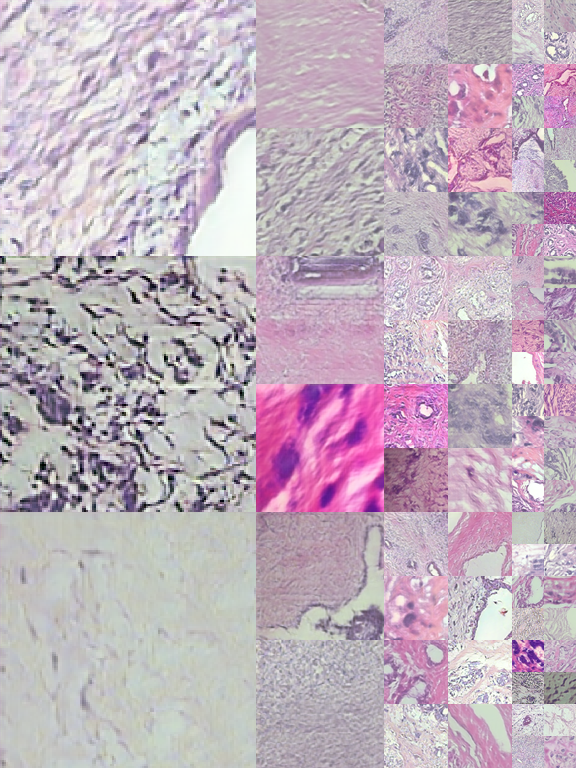

In [17]:
canvas